## Classical Methods - Backtesting

Backtesting of classical portfolio optimization methods. Implemented for comparison with AI models (described in chapter 4.9).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hierarchical_risk_parity as hrp

import os
os.chdir(os.path.expanduser('../data'))

from dotenv import load_dotenv
load_dotenv()

from DataProvider import DataProvider

In [2]:
data_provider = DataProvider()
df_countries, benchmark = data_provider.get_etf_data()
df_returns = df_countries.pct_change().dropna()
days_to_recalculate = data_provider.get_days_to_recalculate()

In [3]:
test_split = int(0.8 * 288)
dates_for_test = days_to_recalculate[test_split:]

### Helper methods

In [4]:
days_no = 126

In [5]:
def get_minimum_variance_weights(df_returns, dates_for_test):
    df_weights = pd.DataFrame(index=dates_for_test,
                              columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-days_no:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights.loc[date] = hrp.compute_minimum_variance_weights(
            returns_fit)

    df_weights.fillna(0, inplace=True)
    return df_weights.values

In [6]:
def get_risk_parity_weights(df_returns, dates_for_test):
    df_weights = pd.DataFrame(index=dates_for_test,
                              columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-days_no:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights.loc[date] = hrp.compute_risk_parity_weights(
            returns_fit)

    df_weights.fillna(0, inplace=True)
    return df_weights.values

In [7]:
def get_weights_hrp(df_returns, dates_for_test, denoise_method):
    df_weights_hrp = pd.DataFrame(index=dates_for_test,
                                  columns=df_returns.columns)

    for date in dates_for_test:
        returns_fit = df_returns[:date].iloc[-days_no:-1]
        if date > pd.to_datetime('2022-03'):
            returns_fit = returns_fit.drop(columns='Russia')
        df_weights_hrp.loc[date] = hrp.compute_HRP_weights(
            returns_fit, denoise_method=denoise_method)

    df_weights_hrp.fillna(0, inplace=True)
    return df_weights_hrp.values

### Backtesting

In [8]:
os.chdir(os.path.expanduser('../models'))
from helper_functions import calculate_returns_for_predictions, calculate_metrics

In [9]:
benchmark_test = benchmark[dates_for_test[0]:]
benchmark_returns = np.log(benchmark_test).diff().dropna()
cum_benchmark_returns = (1 + benchmark_returns).cumprod() - 1
cum_benchmark_returns.loc[dates_for_test[0]] = 0
cum_benchmark_returns.sort_index(inplace=True)

In [10]:
dates_for_test.insert(29, df_countries.index.values[-1])
df_prices_test = df_countries[dates_for_test[0]:]
df_returns_test = np.log(df_prices_test).diff().fillna(0)

In [11]:
equal_weights = np.ones((len(dates_for_test), df_returns.shape[1]))/df_returns.shape[1]
total_returns_equal, cum_total_returns_equal = calculate_returns_for_predictions(
    equal_weights, dates_for_test, df_returns_test)

In [12]:
weights_min_var = get_minimum_variance_weights(df_returns, dates_for_test)
total_returns_min_var, cum_total_returns_min_var = calculate_returns_for_predictions(
    weights_min_var, dates_for_test, df_returns_test)

In [13]:
weights_risk_parity = get_risk_parity_weights(df_returns, dates_for_test)
total_returns_risk_parity, cum_total_returns_risk_parity = calculate_returns_for_predictions(
    weights_risk_parity, dates_for_test, df_returns_test)

In [14]:
weights_hrp = get_weights_hrp(df_returns, dates_for_test, denoise_method=0)
total_returns_hrp, cum_total_returns_hrp = calculate_returns_for_predictions(
    weights_hrp, dates_for_test, df_returns_test)

In [15]:
weights_hrp_denoise_v1 = get_weights_hrp(df_returns, dates_for_test, denoise_method=1)
total_returns_hrp_denoise_v1, cum_total_returns_hrp_denoise_v1 = calculate_returns_for_predictions(
    weights_hrp_denoise_v1, dates_for_test, df_returns_test)

In [16]:
weights_hrp_denoise_v2 = get_weights_hrp(df_returns, dates_for_test, denoise_method=2)
total_returns_hrp_denoise_v2, cum_total_returns_hrp_denoise_v2 = calculate_returns_for_predictions(
    weights_hrp_denoise_v2, dates_for_test, df_returns_test)

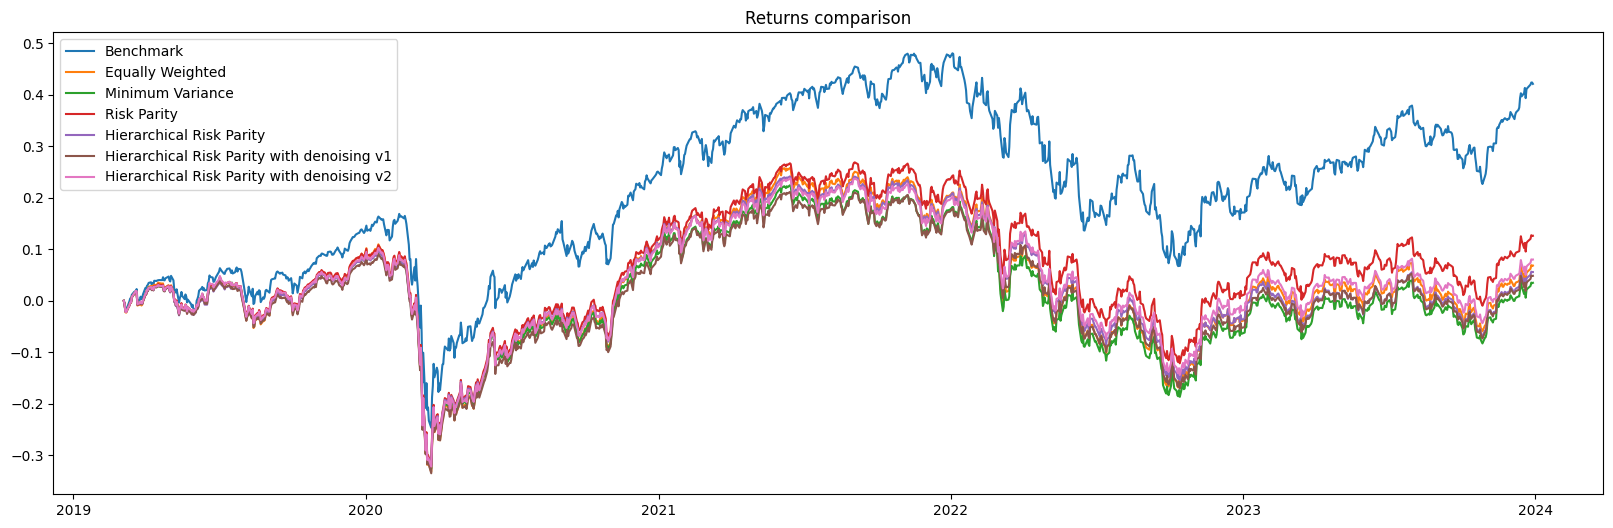

In [19]:
plt.figure(figsize=(20, 6))
plt.plot(cum_benchmark_returns, label='Benchmark')
plt.plot(cum_total_returns_equal, label='Equally Weighted')
plt.plot(cum_total_returns_min_var, label='Minimum Variance')
plt.plot(cum_total_returns_risk_parity, label='Risk Parity')
plt.plot(cum_total_returns_hrp, label='Hierarchical Risk Parity')
plt.plot(cum_total_returns_hrp_denoise_v1, label='Hierarchical Risk Parity with denoising v1')
plt.plot(cum_total_returns_hrp_denoise_v2, label='Hierarchical Risk Parity with denoising v2')
plt.legend()
plt.title('Returns comparison')
plt.show()

In [18]:
df_results = pd.DataFrame(columns=['Annual Returns', 
                                   'Annual Volatility',
                                   'Sharpe Ratio',
                                   'Sortino Ratio',
                                   'Max Drawdown',
                                   'Max Time Under Water',
                                   'Calmar Ratio',
                                   'Information Ratio'])

calculate_metrics(benchmark_returns, df_results, 'Benchmark')
calculate_metrics(total_returns_equal, df_results,  'Equally Weighted', benchmark_returns)
calculate_metrics(total_returns_min_var, df_results, 'Minimum Variance', benchmark_returns)
calculate_metrics(total_returns_risk_parity, df_results, 'Risk Parity', benchmark_returns)
calculate_metrics(total_returns_hrp, df_results, 'Hierarchical Risk Parity', benchmark_returns)
calculate_metrics(total_returns_hrp_denoise_v1, df_results, 'Hierarchical Risk Parity with denoising v1', benchmark_returns) # denoising by fixing random eigenvalues
calculate_metrics(total_returns_hrp_denoise_v2, df_results, 'Hierarchical Risk Parity with denoising v2', benchmark_returns) # denoising through targeted shrinkage

df_results = df_results.astype(float).round(4)
df_results

,Annual Returns,Annual Volatility,Sharpe Ratio,Sortino Ratio,Max Drawdown,Max Time Under Water,Calmar Ratio,Information Ratio
Benchmark,0.0768,0.2033,0.3775,0.4420,-0.3548,500.0,0.2163,0.0000
Equally Weighted,0.0144,0.2103,0.0686,0.0780,-0.3978,641.0,0.0363,-0.8602
Minimum Variance,0.0078,0.1995,0.0390,0.0441,-0.3872,641.0,0.0201,-1.0246
Risk Parity,0.0256,0.1985,0.1289,0.1458,-0.3841,583.0,0.0666,-0.8046
Hierarchical Risk Parity,0.0120,0.1965,0.0609,0.0687,-0.3811,641.0,0.0314,-0.9966
Hierarchical Risk Parity with denoising v1,0.0105,0.1970,0.0533,0.0598,-0.3899,641.0,0.0269,-1.0250
Hierarchical Risk Parity with denoising v2,0.0168,0.1962,0.0854,0.0959,-0.3846,641.0,0.0435,-0.9143
